## Random Forest로 부동산 가격 예측하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

## 1. Data

- 캘리포니아주의 집 값을 예측하는 데이터.

### 1.1 Data Load

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [3]:
data, target = housing['data'], housing['target']

- 빠른 실습을 위해서 데이터는 1/10로 줄임.

In [4]:
data.shape

(20640, 8)

In [5]:
data = data[:2000]
target = target[:2000]

### 1.2 EDA

In [6]:
pd.DataFrame(data, columns=housing['feature_names']).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.885417,31.310500,5.894044,1.151377,1243.354500,2.722148,38.066565,-121.940045
std,1.910350,14.050331,5.124791,1.093032,965.900959,0.757496,0.655932,0.571707
min,0.499900,2.000000,1.714286,0.526316,18.000000,1.280603,36.720000,-124.300000
25%,2.536800,19.000000,4.698539,1.006504,691.000000,2.349835,37.740000,-122.240000
50%,3.508600,32.000000,5.424636,1.051638,1002.500000,2.652805,37.860000,-122.090000
75%,4.924075,43.000000,6.281798,1.104526,1495.000000,2.995032,37.992500,-121.900000
max,15.000100,52.000000,141.909091,34.066667,12203.000000,17.177700,41.950000,-119.770000


In [9]:
pd.Series(target).describe()

count    2000.000000
mean        1.919534
std         0.963947
min         0.225000
25%         1.177750
50%         1.742000
75%         2.409250
max         5.000010
dtype: float64

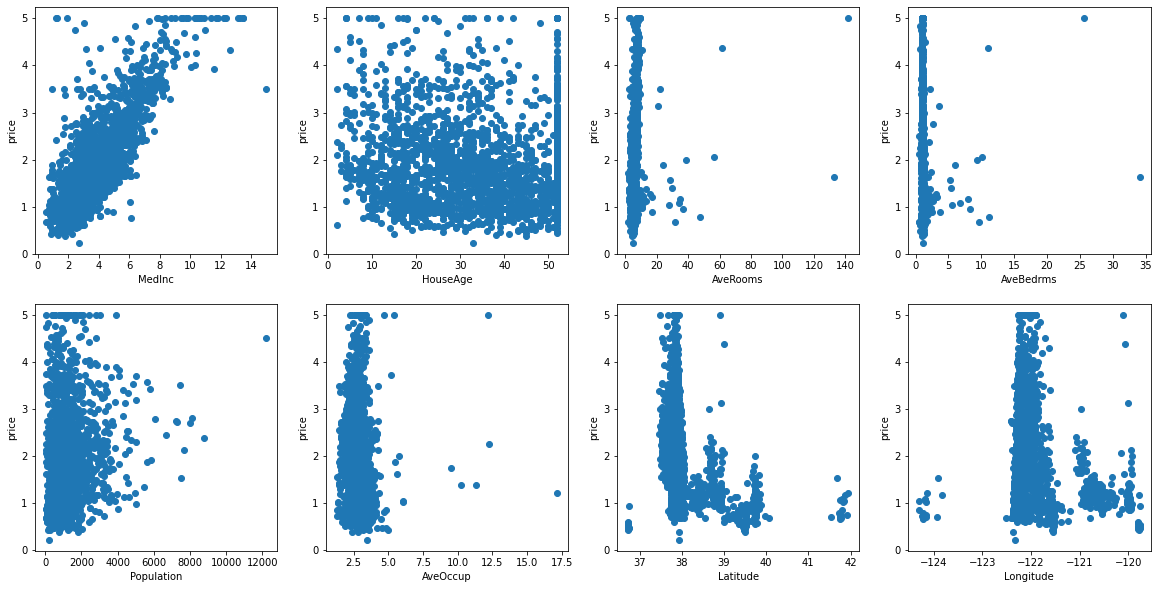

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, feature_name in enumerate(housing['feature_names']):
    ax = axes[i // 4, i % 4]
    ax.scatter(data[:, i], target)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('price')
    
# 세로축이 target.

### 1.3 Data Split

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, train_size=0.7, random_state=2021
)

## 2. Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()

### 2.1 학습

In [15]:
rf_regressor.fit(train_data, train_target)

RandomForestRegressor()

### 2.2 예측

In [16]:
train_pred = rf_regressor.predict(train_data)
test_pred = rf_regressor.predict(test_data)

Text(0, 0.5, 'real')

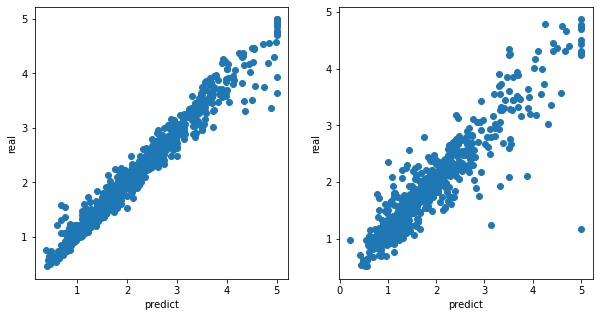

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].scatter(train_target, train_pred)
axes[0].set_xlabel('predict')
axes[0].set_ylabel('real')

axes[1].scatter(test_target, test_pred)
axes[1].set_xlabel('predict')
axes[1].set_ylabel('real')

- 예측이 잘 되었음.

### 2.3 평가

In [18]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_target, train_pred)
test_mse = mean_squared_error(test_target, test_pred)

In [19]:
print(f"train mean squared error is {train_mse:.4f}")
print(f"test mean squared error is {test_mse:.4f}")

train mean squared error is 0.0275
test mean squared error is 0.1497


### 2.4 Feature Importance

<AxesSubplot:>

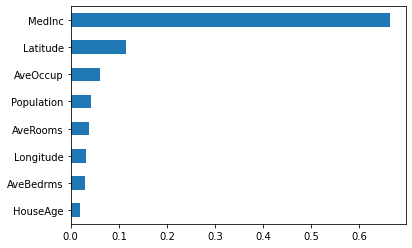

In [21]:
feature_importance = pd.Series(rf_regressor.feature_importances_, index=housing['feature_names'])
feature_importance.sort_values(ascending=True).plot(kind='barh')

- MedInc는 위 EDA 과정에서 target과 높은 상관관계를 보임.

## 3. Best Parameter

In [23]:
from sklearn.model_selection import GridSearchCV

- Random Forest Regressor의 argument
    - n_estimators
        - 몇 개의 의사결정나무를 생성할지.
    - criterion
        - 감소 시킬 평가지표.
            - MAE: Mean Absolute Error
            - MSE: Mean Squared Error
    - max_depth
        - 의사결정나무가 가질 수 있는 최대 깊이.

- cf) 분류 문제에서는 criterion이 gini 혹은 entropy

### 3.1 탐색 범위 설정

In [24]:
params = {
    'n_estimators': [100, 200, 500, 1000],
    'criterion': ['mae', 'mse'],
    'max_depth': [i for i in range(1, 10, 2)],
}

In [25]:
params

{'n_estimators': [100, 200, 500, 1000],
 'criterion': ['mae', 'mse'],
 'max_depth': [1, 3, 5, 7, 9]}

In [26]:
cv_rf_regressor = RandomForestRegressor()

### 3.2 탐색

In [27]:
grid = GridSearchCV(estimator=cv_rf_regressor, param_grid=params, cv=3, n_jobs=-1)
grid = grid.fit(train_data, train_target)

- 총 탐색 횟수: 4 * 2 * 5 = 40
    - 40 * 3 = 120
- n_jobs=-1:  사용할 수 있는 모든 jobs를 사용

In [28]:
print(f"Best score of parameter search is: {grid.best_score_:.4f}")

Best score of parameter search is: 0.7755


In [29]:
grid.best_params_

{'criterion': 'mae', 'max_depth': 9, 'n_estimators': 100}

In [30]:
print("Best parameter of best score is")
for key, value in grid.best_params_.items():
    print(f"\t {key}: {value}")

Best parameter of best score is
	 criterion: mae
	 max_depth: 9
	 n_estimators: 100


### 3.3 평가

In [31]:
best_rf = grid.best_estimator_

In [32]:
cv_train_pred = best_rf.predict(train_data)
cv_test_pred = best_rf.predict(test_data)

Text(0, 0.5, 'real')

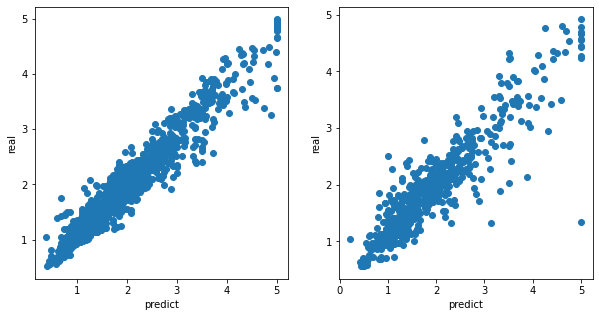

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].scatter(train_target, cv_train_pred)
axes[0].set_xlabel('predict')
axes[0].set_ylabel('real')

axes[1].scatter(test_target, cv_test_pred)
axes[1].set_xlabel('predict')
axes[1].set_ylabel('real')

In [35]:
cv_train_mse = mean_squared_error(train_target, cv_train_pred)
cv_test_mse = mean_squared_error(test_target, cv_test_pred)

In [36]:
print(f"Best model Train mean squared error is {cv_train_mse:.4f}")
print(f"Best model Test mean squared error is {cv_test_mse:.4f}")

Best model Train mean squared error is 0.0584
Best model Test mean squared error is 0.1554


<AxesSubplot:>

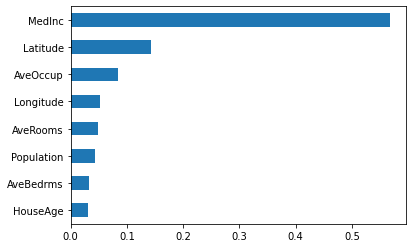

In [37]:
cv_feature_importance = pd.Series(best_rf.feature_importances_, index=housing['feature_names'])
cv_feature_importance.sort_values(ascending=True).plot(kind='barh')

## 4. 마무리

In [38]:
print(f"Test mean squared error is {test_mse:.4f}")
print(f"Best model Test mean squared error is {cv_test_mse:.4f}")

Test mean squared error is 0.1497
Best model Test mean squared error is 0.1554


- Tuning을 한 모델이 더욱 낮은 성능을 보임.

<AxesSubplot:>

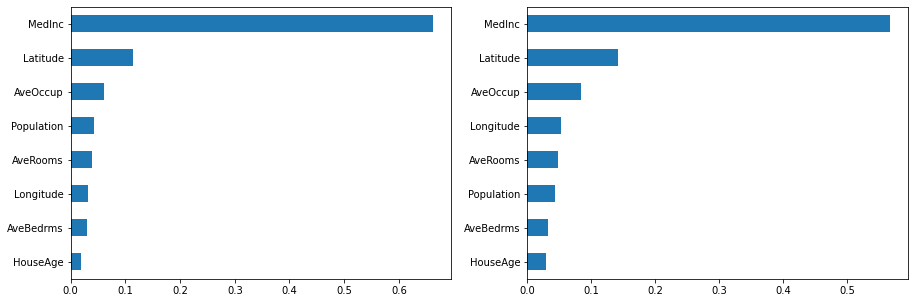

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
feature_importance.sort_values(ascending=True).plot(kind='barh', ax=axes[0])
cv_feature_importance.sort_values(ascending=True).plot(kind='barh', ax=axes[1])